<a href="https://colab.research.google.com/github/javiervasquezufm/ELEMENTS-OF-MACHINE-LEARNING/blob/master/RegresionLogistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboatorio 3

En este laboratorio usaremos cuatro tipo de clasificadores sobre datos de bolsa de valores para predecir si el mercado está de subida o de bajada para cierta fecha. Los datos están en https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Data/Smarket.csv.

In [0]:
import sklearn
sklearn.__version__

'0.20.2'

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [0]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score

print("Todos los paquetes han sido importados:")
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Matplotlib version: {}".format(matplotlib.__version__))
print("Seaborn version: {}".format(sns.__version__))
print("Statsmodels-learn version: {}".format(statsmodels.__version__))

Todos los paquetes han sido importados:
Numpy version: 1.14.6
Pandas version: 0.22.0
Matplotlib version: 3.0.2
Seaborn version: 0.7.1
Statsmodels-learn version: 0.8.0


## Explorando los datos

Las variables en smarket son


*   Año
*   Lag1 a Lag5: porcentaje de retornos de los cinco días previos
*   Volume: el número de intercambios el día previo en billones
*   Today: porcentaje de retorno en ese día
*   Direction: si el mercado está de subida o bajada ese día

In [0]:
url = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Smarket.csv'
smarket = pd.read_csv((url),parse_dates = True)
smarket = smarket.drop('Unnamed: 0', axis=1)

smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [0]:
smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


Predeciremos direction, que esperamos que sea binario. Verifiquemos que lo es

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


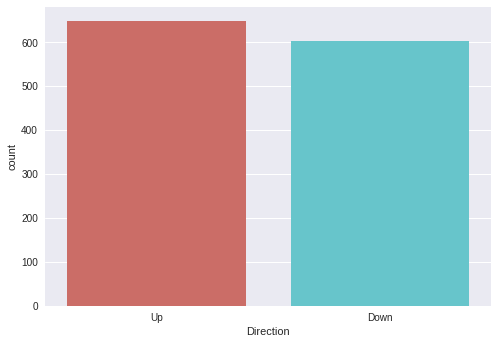

In [0]:
sns.countplot(x='Direction',data=smarket, palette='hls')

Generamos una matriz de correlaciones entre variables para visualizar 

['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today', 'Direction']


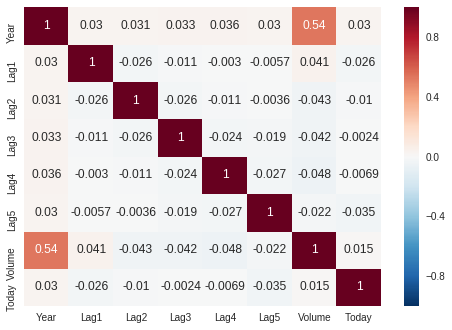

In [0]:
#smarket.corr()

cols = list(smarket)
print(cols)

coefs = np.corrcoef(smarket[cols[0:8]].values.T)
heatMap = sns.heatmap(coefs, annot = True, yticklabels=cols[0:8], xticklabels=cols)

Noten que excluí la columna de Direction porque no es numérica. La única correlación que sobresale es entre volumen y años con 0.539006, las demás son menores a 0.05. Esto último era de esperarse: no parece haber correlacción entre los retornos de hoy y los de días anteriores. Generemos una función de gráfica de dispersión para visualizar la relación entre volumen y año.

In [0]:
def make_scatter_plot(dataframe, input_feature, target,
                      slopes=[], biases=[], model_names=[]):
  """ Creates a scatter plot of input_feature vs target along with the models.
  
  Args:
    dataframe: the dataframe to visualize
    input_feature: the input feature to be used for the x-axis
    target: the target to be used for the y-axis
  """      
  # Define some colors to use that go from blue towards red
  colors = [cm.coolwarm(x) for x in np.linspace(0, 1, len(slopes))]
  
  # Generate the Scatter plot
  x = dataframe[input_feature]
  y = dataframe[target]
  plt.ylabel(target)
  plt.xlabel(input_feature)
  plt.scatter(x, y, color='black', label="")

### Ejercicio

En el laboratorio utilizarás los métodos de clasificación: regresión logística, análisis de discriminante lineal, análisis de discriminante cuadrático y vecinos k-cercanos. Para smarket, cuál crees que será el mejor predictor o el más apropiado para la variable Direction? Los aspectos que debes tomar en cuenta son: número de observaciones, normalidad de la distribución de los datos, no linealidad entre la relación entre los predictores y el target. Responde en la celda de abajo

Desde mi punto de vista el que mayor informacion da es el de la regresion logistica, puesto que nos da una idea de la relevacia que tiene el target con respecto a los predictores. Ya que nos da el coeficiente que apartir de cierto valor es un predictor relevante, y el coefiiente z. Tiene una informacion mas completa. 

## Análisis (Tarea)

Para cada uno de los cuatro métodos de clasificación, escoge observaciones de entrenamiento y otras de prueba

1.   Genera un modelo de predicción para la variable Direction usando observaciones de entrenamiento
2.   Realiza cuadros de confusión para cada uno



### Regresión logística

In [0]:
formula = 'Direction ~ Lag1+Lag2+Lag3+Lag4+Lag5+Volume'

model = smf.glm(formula=formula, data=smarket, family=sm.families.Binomial())
result = model.fit()
print(result.summary2())

                         Results: Generalized linear model
Model:              GLM                                  AIC:            1741.5841 
Link Function:      logit                                BIC:            -7136.1232
Dependent Variable: ['Direction[Down]', 'Direction[Up]'] Log-Likelihood: -863.79   
Date:               2019-02-13 16:17                     LL-Null:        -865.59   
No. Observations:   1250                                 Deviance:       1727.6    
Df Model:           6                                    Pearson chi2:   1.25e+03  
Df Residuals:       1243                                 Scale:          1.0000    
Method:             IRLS                                                           
----------------------------------------------------------------------------------------
                  Coef.       Std.Err.         z         P>|z|        [0.025      0.975]
----------------------------------------------------------------------------------------
In

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
print (confusion_matrix(smarket["Direction"], predictions_nominal))

[[145 457]
 [141 507]]


### Análisis de discriminante lineal

In [0]:
LAD = LinearDiscriminantAnalysis()
model = LAD.fit(X_train, y_train)

print(model.priors_)

[0.49198397 0.50801603]


In [0]:
print(model.means_)

[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]


In [0]:
print(model.coef_)

[[-0.05544078 -0.0443452 ]]


In [0]:
print(confusion_matrix(pred, y_test))

[[ 35  35]
 [ 76 106]]


In [0]:
max(pred_p[:,1])

0.5422132554518978

### Análisis de discriminante cuadrático

In [0]:
QDA = QuadraticDiscriminantAnalysis()
model2 = QDA.fit(X_train, y_train)


In [0]:
print (model2.priors_)
print (model2.means_)

[0.49198397 0.50801603]
[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]


In [0]:
pred2=model2.predict(X_test)
print(confusion_matrix(pred2, y_test))

[[ 30  20]
 [ 81 121]]


### Vecinos k-cercanos

In [0]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
url = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Smarket.csv'
smarket = pd.read_csv((url),parse_dates = True,usecols=range(1,10), index_col=0)

In [0]:
X_train = smarket[:'2004'][['Lag1','Lag2']]
y_train = smarket[:'2004']['Direction']
X_test = smarket['2005':][['Lag1','Lag2']]
y_test = smarket['2005':]['Direction']

In [0]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)

[[43 58]
 [68 83]]


In [0]:
knn = neighbors.KNeighborsClassifier(n_neighbors=100)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)

[[52 61]
 [59 80]]
